# Notebook for running makeBrighterFatterKernel.py on ComCam data.

Initially written 20 Nov 2019 by Craig Lage.
As of this writing, this needs the tickets/DM-18683 branch of cp_pipe.
To implement this, do the following in a terminal:\
source /opt/lsst/software/stack/loadLSST.bash\
setup lsst_distrib

Then, in your home directory, download cp_pipe:\
cd my_dir\
git clone https://github.com/lsst/cp_pipe.git \
cd cp_pipe\
git checkout tickets/DM-18683\
setup -j -r .\
scons\
cd ~/notebooks \
add the following line to the .user_setups file: \
setup -j -r /home/cslage/alternate_branches/cp_pipe

Now when you launch a notebook, it will use your local version of cp_pipe instead of the released version.  You can edit the cp_pipe/python/lsst/cp/pipe/makeBrighterFatterKernel.py code if you want to make changes.



In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          18.1.0-2-gb0efc0e+55 	current w_2019_46 setup


In [15]:
import os, sys, time, datetime, glob, subprocess
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import astropy.io.fits as pf
from scipy import stats
import eups
check_eups = subprocess.Popen('eups list -s | grep lsst_distrib',shell=True)
subprocess.Popen.wait(check_eups)
check_local = subprocess.Popen('eups list -s | grep LOCAL',shell=True)
subprocess.Popen.wait(check_local)
from lsst.daf.persistence import Butler
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask

In [3]:
DETECTOR=4 # Do S11 only
raftName = 'R22'
REPO_DIR = '/project/shared/comCam'
OUTPUT_DIR = '/home/cslage/ComCam/20191113/'
starting_visit = 2019111300120
ending_visit = 2019111300210

In [4]:
comCam_data = Butler(inputs=REPO_DIR)
md = comCam_data.get('raw', visit=starting_visit, raftName=raftName, detector=DETECTOR)
# Below is just a check to make sure we have found the data
print(md.getMetadata()['DATE-OBS'])

2019-11-13T18:58:46.445


In [5]:
pairs = []
visit_1 = starting_visit
while visit_1 < ending_visit:
    pairs.append('%s,%s'%(str(visit_1),str(visit_1+2)))
    visit_1 += 4
print(pairs)
print(len(pairs))

['2019111300120,2019111300122', '2019111300124,2019111300126', '2019111300128,2019111300130', '2019111300132,2019111300134', '2019111300136,2019111300138', '2019111300140,2019111300142', '2019111300144,2019111300146', '2019111300148,2019111300150', '2019111300152,2019111300154', '2019111300156,2019111300158', '2019111300160,2019111300162', '2019111300164,2019111300166', '2019111300168,2019111300170', '2019111300172,2019111300174', '2019111300176,2019111300178', '2019111300180,2019111300182', '2019111300184,2019111300186', '2019111300188,2019111300190', '2019111300192,2019111300194', '2019111300196,2019111300198', '2019111300200,2019111300202', '2019111300204,2019111300206', '2019111300208,2019111300210']
23


In [6]:
# This calculates the covariances and generates the BF Kernel
# It takes a while!  About 30 minutes for one CCD
# Once this has been run, you don't need to run it again to generate the plots
args = [REPO_DIR, '--output', OUTPUT_DIR, '--id', 'detector=%d'%DETECTOR,  '--visit-pairs']
for pair in pairs:
    args.append(str(pair))
args = args + ['-c','xcorrCheckRejectLevel=2', 'doCalcGains=True', 'level="AMP"', 'forceZeroSum=True', 'biasCorr=1.0',
                   'correlationModelRadius=3', 'correlationQuadraticFit=True', 'doPlotPtcs=True', 'isr.doSuspect=False',
                   'maxMeanSignal=100000',
                   '--clobber-config', '--clobber-versions']

corr_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/pex_config/18.1.0-6-gae77429+3/python/lsst/pex/config/config.py:1289: FutureWarning: Config field isr.doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  FutureWarning)
/home/cslage/alternate_branches/cp_pipe/python/lsst/cp/pipe/makeBrighterFatterKernel.py:1185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, _, _, _ = np.linalg.lstsq(TEST, y)


In [6]:
# Now we can get the extracted covariances and kernels and plot them
bf_butler = Butler(OUTPUT_DIR)
bf_kernel = bf_butler.get('brighterFatterKernel', dataId={'detector': DETECTOR})
gain_data = bf_butler.get('brighterFatterGain', dataId={'detector': DETECTOR})

gains = gain_data.gains
ptcResults = gain_data.ptcResults # Quadratic fit
means = bf_kernel.means # Mean flux of flat pairs in electrons
rawMeans = bf_kernel.rawMeans # Mean flux of flat pairs in electrons
rawXcorrs = bf_kernel.rawXcorrs # Raw extracted covariances in ADU^2. [0,0] is the variance}
xcorrs = bf_kernel.xCorrs # reduced covariances in e-^2
meanXcorrs = bf_kernel.meanXcorrs # Extracted covariances used to extract kernel. These are per e-.
kernels = bf_kernel.ampwiseKernels # ampwise kernel

In [7]:
# Just a check to make sure we got what we wanted
print(means.keys()) # Amp names
print(gains)

dict_keys(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00'])
{'C10': 1.0396228761365935, 'C11': 1.0239509875829587, 'C12': 1.0358757082970722, 'C13': 1.034988772181896, 'C14': 1.040816058626625, 'C15': 0.9882524093898181, 'C16': 1.035070000955673, 'C17': 1.0048758333283165, 'C07': 1.0098874259648194, 'C06': 1.0475933721854394, 'C05': 1.0663216737333465, 'C04': 1.0783956800319316, 'C03': 1.0699427151573724, 'C02': 1.0938614764921957, 'C01': 1.0769365102846946, 'C00': 1.0939239554599571}


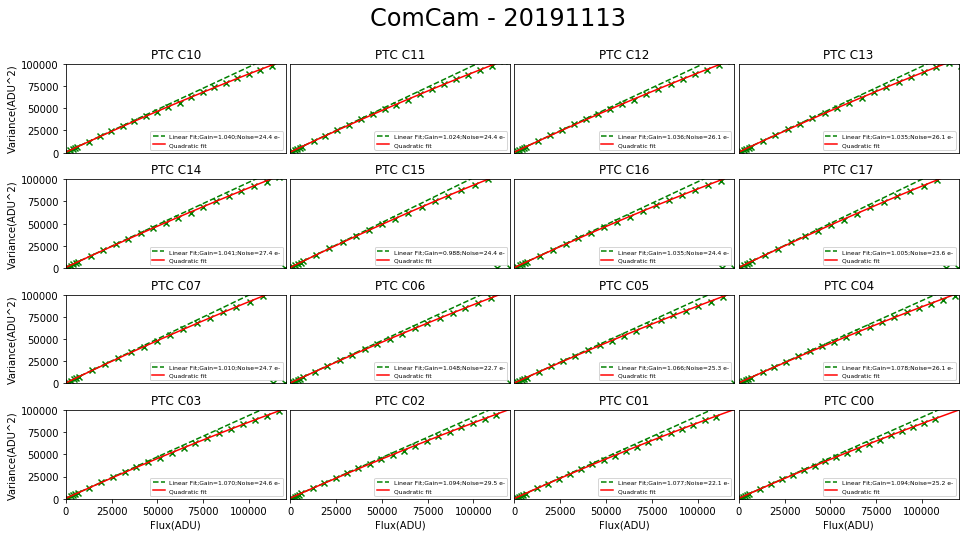

In [10]:
# Next, reproduce the Photon Transfer Curves
date = OUTPUT_DIR.split('/')[4]
plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.3,wspace=0.02)
plt.suptitle("ComCam - %s"%date,fontsize = 24)
plotcounter = 0

for amp in means.keys():
    plotcounter += 1
    plt.subplot(4,4,plotcounter)
    plt.title("PTC %s"%amp,fontsize=12)
    data = []
    for m, [flux1,flux2] in enumerate(rawMeans[amp]):
        flux = (flux1 + flux2)/2.0
        var = rawXcorrs[amp][m][0,0] / 2.0 # Divide by two because variance of a flat difference is 2X.
        data.append([flux, var])
    data.sort()
    data = np.array(data)
    quad_fit = np.polyfit(data[:,0], data[:,1], 2)
    plt.scatter(data[:,0], data[:,1],marker='x',color='green')
    gain = 1.0 / ptcResults[amp][1]
    rms_noise = np.sign(ptcResults[amp][0]) * np.sqrt(abs(ptcResults[amp][0])) * gain
    xplot=np.linspace(0.0, 120000.0, 100)
    yplot_quad = ptcResults[amp][2]*xplot*xplot + ptcResults[amp][1]*xplot + ptcResults[amp][0]
    yplot_linear = ptcResults[amp][1]*xplot + ptcResults[amp][0]
    plt.plot(xplot,yplot_linear,color='green', ls='--',label='Linear Fit;Gain=%.3f;Noise=%.1f e-'%(gain,rms_noise))
    plt.plot(xplot,yplot_quad,color='red', label='Quadratic fit')

    plt.ylim(0,100000)
    plt.xlim(0,120000)
    #plt.xticks([0,10000,20000])
    #plt.yticks([0,2000,4000])
    plt.tick_params(left=False,  bottom=False, labelleft=False,  labelbottom=False)
    if plotcounter in [1,5,9,13]:
        plt.ylabel("Variance(ADU^2)",fontsize=10)
        plt.tick_params(left=True, labelleft=True)
    if plotcounter in [13,14,15,16]:
        plt.xlabel("Flux(ADU)", fontsize=10)
        plt.xticks([0,25000,50000,75000,100000])
        plt.tick_params(bottom=True, labelbottom=True)
        
    plt.legend(loc = 'lower right', fontsize = 6)
plt.savefig(OUTPUT_DIR+'plots/PTC_Quad_All_%s_%s.pdf'%(date,DETECTOR))

In [12]:
# Next plot the covariance vs flux 
date = OUTPUT_DIR.split('/')[4]
NumPairs = 1 # Number of pairs at each flux
fluxLevel = 80000.0
PlotDelta = 5 # Number of pixels to look at
pdf = PdfPages(OUTPUT_DIR+"plots/Covariance_vs_Flux_%s_%s.pdf"%(date,DETECTOR))
for amp in means.keys():
    gain = gains[amp]
    NumFluxes = int(len(rawMeans[amp]) / NumPairs)
    fig = plt.figure(figsize = (16,8))
    plt.suptitle("Covariance vs Flux - Amp %s"%amp, fontsize = 24)
    plt.subplots_adjust(wspace=0.3, hspace=0.6)
    plotcounter = 0
    for jj in range(PlotDelta-1, -1, -1):
        for ii in range(PlotDelta):
            cov_mean = []
            cov_std = []
            flux_mean = []
            plotcounter += 1
            plt.subplot(PlotDelta, PlotDelta, plotcounter)
            cov = []
            flux = []

            for n in range(NumFluxes):
                cov_per_flux = []
                flux_per_flux = []
                for m in range(NumPairs):
                    i = n * NumPairs + m
                    xcorr = rawXcorrs[amp][i][ii,jj] / 2.0 * gain**2
                    mean = (rawMeans[amp][i][0] + rawMeans[amp][i][1]) / 2.0 * gain
                    # Throw out values not in the means array
                    badValue = True
                    for (goodMean0, goodMean1) in means[amp]:
                        if abs((mean - goodMean0) / mean) < 0.01:
                            badValue = False
                            break
                    if badValue:
                        continue
                    if ii == 0 and jj == 0:
                        # This is right, but needs double-checking
                        xcorr = xcorr - (mean / gain * ptcResults[amp][1] + ptcResults[amp][0])*gain**2
                        cov.append(-xcorr)
                        cov_per_flux.append(-xcorr)
                    else:
                        cov.append(xcorr)
                        cov_per_flux.append(xcorr)
                    flux.append(mean)
                    flux_per_flux.append(mean)
                if len(cov_per_flux) == 0:
                    continue
                cov_per_flux = np.array(cov_per_flux)
                flux_per_flux = np.array(flux_per_flux)
                cov_mean.append(cov_per_flux.mean())
                cov_std.append(cov_per_flux.std())
                flux_mean.append(flux_per_flux.mean())
            cov = np.array(cov)
            flux = np.array(flux)
            plt.scatter(flux, cov, color='blue', marker='.', s=20)
            cov_mean = np.array(cov_mean)
            cov_std = np.array(cov_std)
            flux_mean = np.array(flux_mean)
            cov_mean = cov_mean#*flux_mean*flux_mean
            cov_std = cov_std#*flux_mean*flux_mean

            plt.errorbar(flux_mean,cov_mean,yerr=cov_std,color='green',marker='x',ls='None')  
            
            if ii == 0 and jj == 0:
                corrValue = meanXcorrs[amp][jj+8,ii+8]*fluxLevel*fluxLevel
            else:
                corrValue = -meanXcorrs[amp][jj+8,ii+8]*fluxLevel*fluxLevel
            plt.scatter(fluxLevel, corrValue, color = 'red', marker='o')
            plt.title("Pixel: (%d, %d)"%(ii, jj), fontsize = 12)
            coefs = np.polyfit(flux*flux, cov, 1)
            xplot = np.linspace(0,150000, 100)
            yplot = max(0, coefs[0])*xplot*xplot
            plt.plot(xplot,yplot, color = 'red', lw = 2)
            if jj == 0:
                plt.xlabel("Central Pixel Charge(e-)", fontsize = 12)
            if ii == 0:
                plt.ylabel("Correlation", fontsize = 12)
            plt.xlim(0,120000)
            plt.xticks([0,100000],fontsize = 12)
            if ii == 0 and jj == 0:
                plt.yticks([0,10000],fontsize = 12)
                plt.ylim(-1000,30000)
            elif ii == 0 and jj == 1:
                plt.yticks([0,2000,4000],fontsize = 12)
                plt.ylim(-500,4000)
            elif ii == 2 and jj == 0:
                plt.yticks([0,500,1000],fontsize = 12)
                plt.ylim(-100,1000)
            elif ii == 1 and jj < 2:
                plt.yticks([0,1000,2000],fontsize = 12)
                plt.ylim(-500,2000)
            else:
                plt.yticks([-200,0,200],fontsize = 12)
                plt.ylim(-200,500)

    pdf.savefig(fig)  # saves the current figure into a pdf page
    plt.close()
pdf.close()


In [13]:
# Now plot the correlations and the kernel. 
date = OUTPUT_DIR.split('/')[4]
pdf = PdfPages(OUTPUT_DIR+"plots/Corr_Kernel_Comparison_%s_%s.pdf"%(date,DETECTOR))
for amp in means.keys():
    fig = plt.figure(figsize=(16,5))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("COVARIANCES(*1E7)       Amp %s      KERNEL(*1E7)"%amp, fontsize=24)
    plt.subplot(1,4,1)
    plt.imshow(np.log10(abs(np.array(meanXcorrs[amp]))))
    plt.subplot(1,4,2)
    plt.plot([0,16],[0,0], ls='--', color='black')
    #plt.yticks([])  
    plt.plot(-meanXcorrs[amp][:,8]*1E7, color='blue', drawstyle='steps-mid')
    plt.plot(-meanXcorrs[amp][8,:]*1E7, linestyle='--', color='red', drawstyle='steps-mid')
    plt.ylim(-40,10)
    plt.subplot(1,4,3)
    plt.imshow(kernels[amp])
    plt.subplot(1,4,4)  
    plt.plot([0,16],[0,0], ls='--', color='black')
    plt.plot(kernels[amp][:,8]*1E7, color='blue', drawstyle='steps-mid')
    plt.plot(kernels[amp][8,:]*1E7, linestyle='--', color='red', drawstyle='steps-mid')
    plt.ylim(-10,2)
    pdf.savefig(fig)  # saves the current figure into a pdf page
    plt.close()
pdf.close()


In [16]:
# Plot the correlations as a function of pixel 
date = OUTPUT_DIR.split('/')[4]
pdf = PdfPages(OUTPUT_DIR+"plots/Covariance_Matrix_%s_%s.pdf"%(date,DETECTOR))
NumPairs = 1
NumFluxes = int(len(means['C12']) / NumPairs)
for amp in means.keys():
    try:
        NumFluxes = int(len(means[amp]) / NumPairs)
        posrs = []
        negrs = []
        poscs = []
        negcs = []
        fitrs = []
        fitcs = []
        poserrs = []
        negerrs = []
        for ii in range(17):
            for jj in range(17):
                r2 = (ii-8)**2 + (jj-8)**2
                value = meanXcorrs[amp][ii,jj]
                n = NumFluxes - 1
                cov = []
                for m in range(NumPairs):
                    i = n * NumPairs + m
                    xcorr = xcorrs[amp][i][abs(ii-8),abs(jj-8)]
                    cov.append(xcorr)
                cov = np.array(cov)
                if ii == 8 and jj == 8:
                    negcs.append(abs(value))
                    negrs.append(0.85)
                    negerrs.append(abs(cov.std()))
                elif value < 0.0:
                    poscs.append(abs(value))
                    posrs.append(r2)
                    poserrs.append(abs(cov.std()))
                    if r2 > 1.1 and r2 < 20.0:
                        fitrs.append(np.log10(r2))
                        fitcs.append(np.log10(abs(value)))
                else:
                    negcs.append(abs(value))
                    negrs.append(r2)
                    negerrs.append(abs(cov.std()))

        slope, intercept, r_value, p_value, std_err = stats.linregress(fitrs,fitcs)

        fig = plt.figure(figsize=(16,8))
        plt.title("Covariance Matrix - %s"%amp, fontsize = 24)
        plt.errorbar(posrs, poscs, yerr=poserrs, color='blue', marker = 'o', markersize = 8, ls = '', label = 'Positive Meas')
        plt.errorbar(negrs, negcs, yerr=negerrs, color='red', marker = 'o', markersize = 8, ls = '', label = 'Negative Meas')

        plt.text(1.2, 5E-6, "C00: Meas = %.4g"%(-meanXcorrs[amp][8,8]), fontsize = 24)
        plt.text(1.2, 2.5E-6, "C01: Meas = %.4g"%(-meanXcorrs[amp][9,8]), fontsize = 24)
        plt.text(1.2, 1.25E-6, "C10: Meas = %.4g"%(-meanXcorrs[amp][8,9]), fontsize = 24)
        plt.text(1.2, 6.25E-7, "C11: Meas = %.4g"%(-meanXcorrs[amp][9,9]), fontsize = 24)
        xplot = np.linspace(1.0,200,100)
        yplot = 10.0**intercept * xplot**(slope)
        #plot(xplot,yplot,ls='--',color='green')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(0.8,100)
        plt.ylim(1E-10,1E-5)
        plt.xticks([1.0, 10.0, 100.0], fontsize=24)
        plt.yticks([1E-10, 1E-9, 1E-8, 1E-7, 1E-6, 1E-5], fontsize=24)
        plt.xlabel("$i^2 + j^2$", fontsize = 24)
        plt.ylabel("Covariance or $\delta$ Area/Area", fontsize = 24)
        plt.legend(fontsize=24)
        pdf.savefig(fig)  # saves the current figure into a pdf page
        plt.close()
    except:
        print("Skipping amp %s"%amp)
        continue
pdf.close()